# Titanic Survival Prediction

This is a short lesson on data cleaning and classification prediction, using Kaggle's 
introductory competition, [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic).

If you're looking at this before seeing what the competition is, our goal is to predict whether a passenger of the Titanic survived, given some data. Let's take a look at what the data actually is! 

# Importing the Data
We're going to be using Pandas to work with our data, so we'll simply import our two 
csv files directly into Pandas DataFrames:

In [308]:
import pandas as pd
import numpy as np

train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")

To simplify our data processing, we can combine these two data frames into a single
data frame. Since the test data frame is missing the 'Survived' column, we'll fill 
this in with `np.nan`, so we can remember which rows are test data and which are 
training data later on.

In [309]:
test_df['Survived'] = np.nan
df = train_df.append(test_df, sort=False, ignore_index=True)

With that out of the way, let's start looking at the actual contents of our data and 
then put it into a form that'll best suited for training our classifier.

# Looking at the Data

Now that we've loaded our data, we need to clean it up. Let's take a look at what we're 
dealing with first:

In [310]:
df.dtypes

PassengerId      int64
Survived       float64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [311]:
df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
419,420,0.0,3,"Van Impe, Miss. Catharina",female,10.0,0,2,345773,24.1500,NaN,S
765,766,1.0,1,"Hogeboom, Mrs. John C (Anna Andrews)",female,51.0,1,0,13502,77.9583,D11,S
162,163,0.0,3,"Bengtsson, Mr. John Viktor",male,26.0,0,0,347068,7.7750,NaN,S
901,902,NaN,3,"Ilieff, Mr. Ylio",male,NaN,0,0,349220,7.8958,NaN,S
670,671,1.0,2,"Brown, Mrs. Thomas William Solomon (Elizabeth ...",female,40.0,1,1,29750,39.0000,NaN,S


# Clean-up Time 


If we want to look for linear or binary relationships between 
our data and the survived value of each passenger, we need to convert this human-readable 
data into something that's more easy for a machine to understand: numbers!

Let's go through this column-by-column, explaining the process for each new case as 
we come across it.

# Sex
The 'Sex' column is a great place to start because of its simplicity. There are only 
two cases to worry about, 'male' and 'female', and there isn't any missing data. So all 
we need to do is map these strings to a binary case for a classifier algorithm to understand.

Let's use the mapping `{0: 'female', 1: 'male'}`:

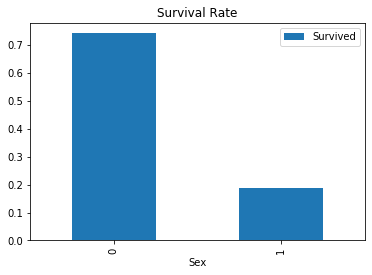

In [312]:
mapping = {
    'female': 0,
    'male': 1
}
df['Sex'] = df['Sex'].apply(lambda x: mapping[x])
_ = df[['Sex', 'Survived']].groupby(['Sex']).agg('mean').plot.bar(title='Survival Rate')

With just one step, we have our first binary column! Simple enough. Now onto the next one...

# Age
The 'Age' column is already in a nice numeric form, but let's take a look into how well 
it actually corresponds to whether a passenger survived in its current state.

In [313]:
pd.isna(df['Age']).sum()

263

Looks like we have some NA values! Considering that age is a nice continuous value, let's just assign
the median age to each missing value.

In [314]:
med_age = np.median(df['Age'][~pd.isna(df['Age'])])
df['Age'] = df['Age'].fillna(med_age)


Now that we have only real values, let's look at the correspondence between age and survival:

In [315]:
df[['Survived', 'Age']].corr()

,Survived,Age
Survived,1.00000,-0.06491
Age,-0.06491,1.00000


Quick refresher on correspondence: this value ranges between -1 and +1. 

A correspondence of 1 means two sets are strongly linearly 
correlated. Ideally, with a correspondence of 1, you could apply a simple formula of the form 
`y = mx + b` to map from one set to the other, with `m` being positive.

A correspondence of -1 means the two sets are strongly linearly correlated as well, just ini the negative 
direction. You can still apply the mapping `y = mx + b`, but now you'd have a negative `m`.

A correspondence of 0 means that the two sets you're looking at have no similarity. There exists no mapping 
from one set to the other.

Back to our data! Seeing that the correspondence between age and survival is nearly zero, we need to 
see if there's anything we can do to actually compare the two columns! One popular method 
of identifying nonlinear correspondence is by binning, or making bins of ages, so we have a bin filled with 
our 0-10 year old passengers, our 11-20 year old passengers, and so on and so forth.

In [316]:
bin_space = 10
bin_walls = range(0, 100, bin_space)
bin_intervals = [pd.Interval(low, low + bin_space) for low in bin_walls]
bins = pd.IntervalIndex(bin_intervals)

age_bin_mapping = {}
for i, b in enumerate(bins):
    age_bin_mapping[b] = i

age_bins = pd.cut(df['Age'], bins=bins)
df['Age_bin'] = age_bins.apply(lambda x: age_bin_mapping[x]).astype(int)

df[['PassengerId', 'Survived', 'Age_bin']][:5]

,PassengerId,Survived,Age_bin
0,1,0.0,2
1,2,1.0,3
2,3,1.0,2
3,4,1.0,3
4,5,0.0,3


Now we have all of our passengers assigned to bins! Let's see what the correspondence is for this...

In [317]:
df[['Survived', 'Age_bin']].corr()

,Survived,Age_bin
Survived,1.000000,-0.051406
Age_bin,-0.051406,1.000000


As expected, the age bins linearly correspond with survival just as little as the raw age did.
There might be a strong correspondence hiding here still, so let's look at the survival rate for each bin:

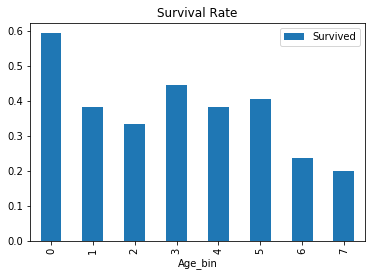

In [318]:
_ = df[['Age_bin', 'Survived']].groupby(['Age_bin']).agg('mean').plot.bar(title='Survival Rate')

Looking at this breakdown, there's definitely some sort of trend. Bin 0 had a much higher 
rate of survival than the others, while bins 6 and 7 had much lower rates of survival. In 
order to extract this in a more machine-readable way, we're going to expand this categorical 
 column into a set of columns, one for each bin, with the value `1` if the row belongs to 
 the bin and `0` otherwise.

In [319]:
age_bins = pd.get_dummies(df['Age_bin']).add_prefix('Age_bin_')
df = df.merge(age_bins, how='left', left_index=True, right_index=True, validate='1:1')
df[:3]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,Age_bin,Age_bin_0,Age_bin_1,Age_bin_2,Age_bin_3,Age_bin_4,Age_bin_5,Age_bin_6,Age_bin_7
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,...,S,2,0,0,1,0,0,0,0,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,...,C,3,0,0,0,1,0,0,0,0
2,3,1.0,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,...,S,2,0,0,1,0,0,0,0,0


Now we have a DataFrame with 8 extra columns, one for each age bin that we had created earlier.
Since we've coded the age column into this new form, we can drop the old columns so we 
don't try to train on different representations of the same data.

In [320]:
df = df.drop(columns=['Age', 'Age_bin'])

# Pclass (Ticket class)
Now that we've finished cleaning up the age data, let's move on to `Pclass`. First, we should look at its
correspondence to see if it's already good or not.

In [321]:
df[['Survived', 'Pclass']].corr()

,Survived,Pclass
Survived,1.000000,-0.338481
Pclass,-0.338481,1.000000


A correspondence of -0.3 is actually fairly strong, compared to our previous examinations
of the age bins. We can break this value down further to see if there are any individual 
ticket classes that show strong individual correspondences with the survival rate.

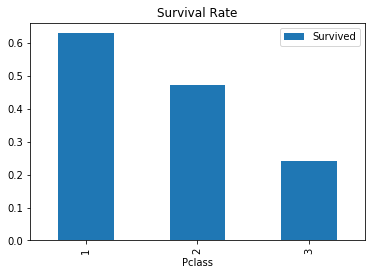

In [322]:
p_classes = sorted(df['Pclass'].unique())

_ = df[['Pclass', 'Survived']].groupby(['Pclass']).agg('mean').plot.bar(title='Survival Rate')

With these survival rates, it looks like there is a pretty nice linear relationship in the 
data already, so we'll leave the Pclass column as-is.

And just to be safe, we should check to make sure that there aren't any missing data
from this column.

In [323]:
len(df[pd.isna(df['Pclass'])])

0

No missing values, good! Now we can move on to the next column to analyze.

# SibSP (Siblings and spouses)

Now we'll look at the column 'SibSp', the number of siblings and spouses each passenger had. As always, let's first take a look at the linear correspondence.

In [324]:
df[['Survived', 'SibSp']].corr()

,Survived,SibSp
Survived,1.000000,-0.035322
SibSp,-0.035322,1.000000


Looks like there's essentially no correspondece here, so we need to dissect these values a bit to see if there's anything more to learn.

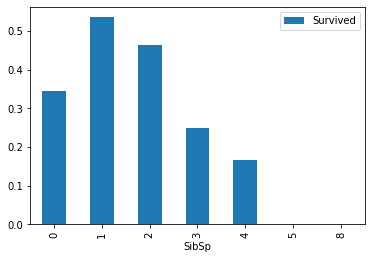

In [325]:
import matplotlib.pyplot as plt

sib_nums = sorted(df['SibSp'].unique())

_ = df[['SibSp', 'Survived']].groupby(['SibSp']).agg('mean').plot.bar()


It seems like there's a line that can be drawn around a 'SibSp' value of 4-5. Families with many siblings or spouses didn't seem to have any survivability, so that'll make for a strong feature in our classifier. Let's make a new binary column for 'LargeSibSp' to track this feature.

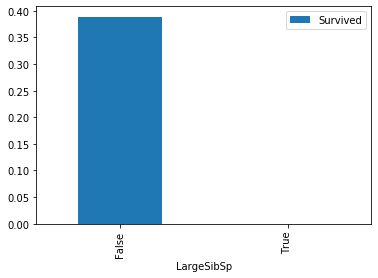

In [326]:
largeSibSpCutOff = 4
df['LargeSibSp'] = df['SibSp'] > largeSibSpCutOff
_ = df[['LargeSibSp', 'Survived']].groupby(['LargeSibSp']).agg('mean').plot.bar()

Now, before moving on to the next feature, let's check for, and clean up, any missing values.

In [327]:
len(df[pd.isna(df['SibSp'])])

0

# Parch (Parents and children)

The number of parents and children seems like a very similar mesaurement to the number of siblings and spouses. We should keep that in mind and come back to that later. For now though, we'll look at this feature on its own.

In [328]:
df[['Survived', 'Parch']].corr()

,Survived,Parch
Survived,1.000000,0.081629
Parch,0.081629,1.000000


No significant correspondence can be observed here, so let's run the same steps we did with 'SibSp':

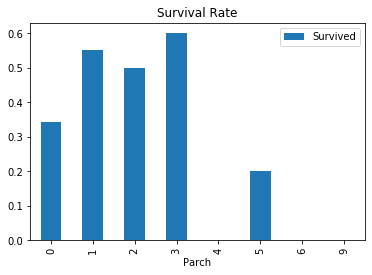

In [329]:
parch_nums = sorted(df['Parch'].unique())

_ = df[['Parch', 'Survived']].groupby(['Parch']).agg('mean').plot.bar(title='Survival Rate')

Just like 'SibSp', 'Parch shows a strong line between small numbers of parents/children and large. This is a bit trickier though; since there is a non-zero survival rate at 5, we can't draw our line of survival as easily as we did for 'SibSp'. Let's try breaking this into three new columns: 'SmallParch', 'MedParch', and 'LargeParch'.

In [330]:
df['SmallParch'] = df['Parch'] <= 3
df['MedParch'] = df['Parch'].between(4, 5)  # Boundaries are included
df['LargeParch'] = df['Parch'] >= 6

Survival for small Parch: 0.39
Survival for medium Parch: 0.11
Survival for large Parch: 0


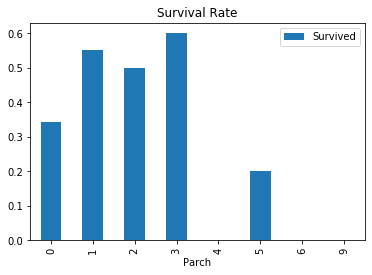

In [331]:
df_s = df[df['SmallParch'] == True]
df_m = df[df['MedParch'] == True]
df_l = df[df['LargeParch'] == True]

_ = df[['Parch', 'Survived']].groupby(['Parch']).agg('mean').plot.bar(title='Survival Rate')

print("Survival for small Parch: {:.2g}".format(len(df_s[df_s['Survived'] == 1]) / len(df_s[~pd.isna(df_s['Survived'])])))
print("Survival for medium Parch: {:.2g}".format(len(df_m[df_m['Survived'] == 1]) / len(df_m[~pd.isna(df_m['Survived'])])))
print("Survival for large Parch: {:.2g}".format(len(df_l[df_l['Survived'] == 1]) / len(df_l[~pd.isna(df_l['Survived'])])))

Before moving on, as usual, we should check for any missing values.

In [332]:
len(df[pd.isna(df['Parch'])])

0

Good! Now, remember that note we wanted to remember earlier about how 'Parch' and 'SibSp' sound very similar? Let's explore that now.

# SibSp + Parch

The columns 'SibSp' and 'Parch' showed very similar trends, so adding the two together might give even better data.

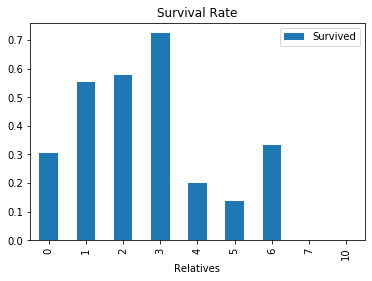

In [333]:
df['Relatives'] = df['SibSp'] + df['Parch']

nums = sorted(df['Relatives'].unique())

_ = df[['Relatives', 'Survived']].groupby(['Relatives']).agg('mean').plot.bar(title='Survival Rate')

It looks like, just as predicted, this data is essentially identical to what we found in each of the two individual columns above. Looking more closely, we can identify an almost-clean bell curve, centered a 'Relatives' size of around 2 or 3. The only data that throws this off is the increase in survivability from 'Relatives' values of 5 to 6. For now, let's ignore that as an anomaly and see if we can capture this Gaussian-like relationship around some ideal family size.

In [334]:
ideal_relatives = 2

df['DistFromIdealRel'] = np.abs(df['Relatives'] - ideal_relatives)

df[['Survived', 'DistFromIdealRel']].corr()

,Survived,DistFromIdealRel
Survived,1.00000,-0.24708
DistFromIdealRel,-0.24708,1.00000


An absolute correspondence of 0.25 is much better than what we started with for 'SibSp' or 'Parch' before (around 0.07), so this seems like it'll be a decent feature. Now we can go back in and drop the original columns from the table so they don't add noise to our results.

In [335]:
df = df.drop(columns=['SibSp', 'Parch', 'Relatives'])

# Fare

So far so good! Next, time to examine the relationship between the fare, or ticket price, and survival rates.

In [336]:
df[['Survived', 'Fare']].corr()

,Survived,Fare
Survived,1.000000,0.257307
Fare,0.257307,1.000000


We already have one of the best correspondences we've seen! Let's keep this column as-is and move on for now.

# Cabin

Now it's time to explore whether a passenger's cabin location had anything to do with survivability. Before checking correspondences, I'd like to get any missing values out of the way.

In [337]:
print("NA values: {}".format(len(df[pd.isna(df['Cabin'])])))

NA values: 1014


We have a fairly significant amount of missing cabin information, so I'd like to hold off on filling in this data until we know what the existing relationship looks like.

Let's first see if the fact that we're missing cabin information can tell us anything about survival rates.

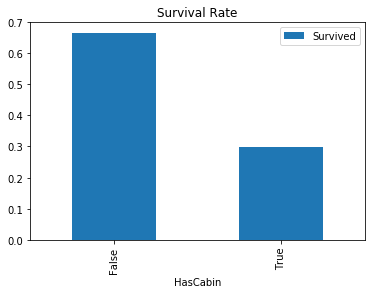

In [338]:
df['HasCabin'] = df['Cabin'].apply(lambda x: pd.isna(x))

_ = df[['HasCabin', 'Survived']].groupby(['HasCabin']).agg('mean').plot.bar(title='Survival Rate')

Surprisingly, it looks like having a cabin on record does affect the survival rate of the passengers (at least in our data set)! In that case, we're going to keep these "no-cabin" labels as their own unique property, while we break down the values for passengers who do have cabins.

For cabin values, we'll start by binning them based on the cabin class (the letter preceding the cabin number). There are a few cabins that have the letter F before their actual cabin class, so let's separate the F-marked passengers for further analysis.

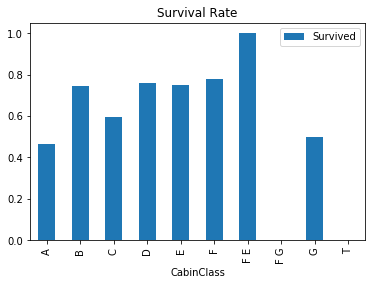

In [339]:

import re
def get_cabin_class(cabin):
    if pd.isna(cabin):
        return np.nan
    
    title_search = re.search('([A-Za-z ]+)', cabin)
    if title_search:
        return title_search.group(1)
    
    return np.nan

df['CabinClass'] = df[~pd.isna(df['Cabin'])]['Cabin'].apply(get_cabin_class)

cabin_classes = sorted(df[~pd.isna(df['CabinClass'])]['CabinClass'].unique())

_ = df[['CabinClass', 'Survived']].groupby(['CabinClass']).agg('mean').plot.bar(title='Survival Rate')

df = df.drop(columns=['CabinClass'])

Interestingly enough, it looks like this doesn't really give us any more information than we already had, aside from a small percentage of outliers in 'F G' and 'T' cabin classes. Maybe we'll circle back around to this to see if there are any slight improvements that can be made from the slight discrepancies between each cabin class...

Oh well, it was worth a shot! Let's just stick with our original finding then, the difference in survival rate between those with a recorded cabin number, and those without.

In [340]:
df['HasCabin'] = ~pd.isna(df['Cabin'])
df = df.drop(columns=['Cabin'])
df[['Survived', 'HasCabin']].corr()

,Survived,HasCabin
Survived,1.000000,0.316912
HasCabin,0.316912,1.000000


# Name

This one will be tricky. Maybe there are correspondences between the survival rates of passengers with certain titles? Let's find out!

In [341]:
def get_title(name):
    if pd.isna(name):
        return np.nan

    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    
    return np.nan

df['Title'] = df['Name'].apply(get_title)
titles = df['Title'].unique()
print(titles)

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer' 'Dona']


There are a few categories we could specify to split this into groups. "Is a doctor", or "is military", or "is married" (for women at least).

Before any of those specifics, let's first just check the survival rate of each of these individually. Along with some extra clean-up combining titles that mean the same thing (and mapping unknown marital status titles to the same thing).

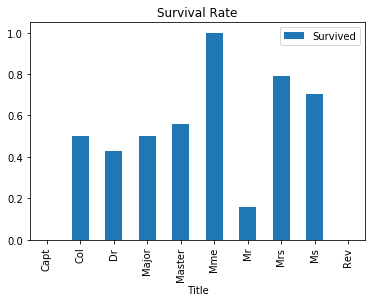

In [342]:
title_map = {
    'Miss': 'Ms',
    'Mlle': 'Ms',
    'Sir':  'Master',
    'Don':  'Master',
    'Jonkheer': 'Master',
    'Countess': 'Mme',
    'Lady':     'Mme',
    'Dona':     'Mme'
}

def map_title(title):
    if pd.isna(title):
        return np.nan
    
    if title in title_map.keys():
        return title_map[title]
    else:
        return title
    
df['Title'] = df['Title'].apply(map_title)
_ = df[['Title', 'Survived']].groupby(['Title']).agg('mean').plot.bar(title='Survival Rate')

Looks like the old saying "the captain must go down with the ship" holds in this case! Also, "Masters" fared much better than men with "Mr". The women with "Mme" also fared quite well, even though there are only 3 in this case. Reverends, on the other hand, all went down with the ship.

For code simplicity, let's just go ahead and expand this column into binary columns like we did previously with age groups.

In [343]:
title_bins = pd.get_dummies(df['Title']).add_prefix('Title_')
df = df.merge(title_bins, how='left', left_index=True, right_index=True, validate='1:1')
df[:3]

,PassengerId,Survived,Pclass,Name,Sex,Ticket,Fare,Embarked,Age_bin_0,Age_bin_1,...,Title_Capt,Title_Col,Title_Dr,Title_Major,Title_Master,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev
0,1,0.0,3,"Braund, Mr. Owen Harris",1,A/5 21171,7.2500,S,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,PC 17599,71.2833,C,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,1.0,3,"Heikkinen, Miss. Laina",0,STON/O2. 3101282,7.9250,S,0,0,...,0,0,0,0,0,0,0,0,1,0


In [344]:
df = df.drop(columns=['Name', 'Title'])

# Embarked

Now, almost done with the basic data cleaning for our data set! Next, it's time to look at the 'Embarked' column. From the data sheet, this column represents a passenger's port of embarkation and is encoded with one of three letters: C (Cherbourg), Q (Queenstown), or S (Southampton). Let's first take a look at the survival rate of passengers from each port to see if there's a trend.

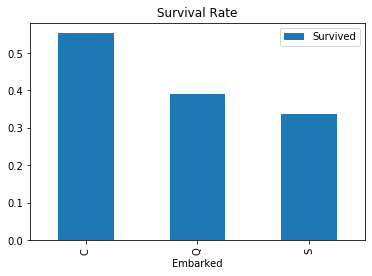

In [345]:
ports = df['Embarked'].unique()

_ = df[['Embarked', 'Survived']].groupby(['Embarked']).agg('mean').plot.bar(title='Survival Rate')

It does look like there might be a trend here that could be worth extracting: passengers from port C show higher survival rates than those from the other two. Let's expand the 'Embarked' column into binary columns. 

Also, since the sample size of passengers with no port data is so small, we should go ahead and just add them to the most common port.

In [346]:
groups = df.groupby('Embarked').size()
most_common_index = groups[groups == max(groups)].index[0]
df['Embarked'] = df['Embarked'].fillna(most_common_index)

print(most_common_index)

S


In [347]:
embarked_bins = pd.get_dummies(df['Embarked']).add_prefix('Embarked_')
df = df.merge(embarked_bins, how='left', left_index=True, right_index=True, validate='1:1')

df = df.drop(columns='Embarked')
df[:3]

,PassengerId,Survived,Pclass,Sex,Ticket,Fare,Age_bin_0,Age_bin_1,Age_bin_2,Age_bin_3,...,Title_Major,Title_Master,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Embarked_C,Embarked_Q,Embarked_S
0,1,0.0,3,1,A/5 21171,7.2500,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
1,2,1.0,1,0,PC 17599,71.2833,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
2,3,1.0,3,0,STON/O2. 3101282,7.9250,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1


# Ticket
Now, for the last field, the tickets. There seems to be a lot going on in this field, so we're going to have to do some string searching gymnastics to uncover any possble correlations to survival rates.

In [348]:
tickets = df['Ticket'].unique()
print(len(tickets))
print(tickets[:20])

929
['A/5 21171' 'PC 17599' 'STON/O2. 3101282' '113803' '373450' '330877'
 '17463' '349909' '347742' '237736' 'PP 9549' '113783' 'A/5. 2151'
 '347082' '350406' '248706' '382652' '244373' '345763' '2649']


All tickets have a number, but only some have prefixes, and that prefix seems to have a hold of variation. Let's start cleaning this up to see how many different prefixes there really are.

In [349]:
def ticket_prefix(ticket):
    if pd.isna(ticket):
        return np.nan

    pref = re.sub('[0-9]+$', '', ticket).strip(' ')
    return pref

df['TicketPrefix'] = df['Ticket'].apply(ticket_prefix)
prefixes = sorted(df['TicketPrefix'].unique())
prefixes

['',
 'A. 2.',
 'A./5.',
 'A.5.',
 'A/4',
 'A/4.',
 'A/5',
 'A/5.',
 'A/S',
 'A4.',
 'AQ/3.',
 'AQ/4',
 'C',
 'C.A.',
 'C.A./SOTON',
 'CA',
 'CA.',
 'F.C.',
 'F.C.C.',
 'Fa',
 'LINE',
 'LP',
 'P/PP',
 'PC',
 'PP',
 'S.C./A.4.',
 'S.C./PARIS',
 'S.O./P.P.',
 'S.O.C.',
 'S.O.P.',
 'S.P.',
 'S.W./PP',
 'SC',
 'SC/A.3',
 'SC/A4',
 'SC/AH',
 'SC/AH Basle',
 'SC/PARIS',
 'SC/Paris',
 'SCO/W',
 'SO/C',
 'SOTON/O.Q.',
 'SOTON/O2',
 'SOTON/OQ',
 'STON/O 2.',
 'STON/O2.',
 'STON/OQ.',
 'SW/PP',
 'W./C.',
 'W.E.P.',
 'W/C',
 'WE/P']

Alright, we've narrowed down the results just a bit. It looks like there are different formats for the same prefix in many cases, like `['A./5', 'A/5.', 'A/5']` or `['C.A.', 'CA']`. We should make an attempt to clean these up.

In [350]:
def simplify_prefix(prefix):
    prefix = prefix.lower()
    prefix = prefix.replace(' ', '')
    prefix = prefix.replace('.', '')
    prefix = prefix.replace('/', '')
    
    return prefix

df['TicketPrefix'] = df['TicketPrefix'].apply(simplify_prefix)
prefixes = sorted(df['TicketPrefix'].unique())
print(prefixes)

['', 'a2', 'a4', 'a5', 'aq3', 'aq4', 'as', 'c', 'ca', 'casoton', 'fa', 'fc', 'fcc', 'line', 'lp', 'pc', 'pp', 'ppp', 'sc', 'sca3', 'sca4', 'scah', 'scahbasle', 'scow', 'scparis', 'soc', 'sop', 'sopp', 'sotono2', 'sotonoq', 'sp', 'stono2', 'stonoq', 'swpp', 'wc', 'wep']


Considering these tickets were all commissioned manually - no computers back then - there could've been discrepencies in the way a ticket master wrote the details. Possibly `sop`, `sp`, and `sopp` were the same classification, as well as the pair `soton` and `ston`. And considering the prefixes starting with 'a', it really looks like `as` was a typo for `a5`. Without making too many assumptions, let's start with just these examples.

In [351]:
def simplify_prefix(prefix):
    prefix = prefix.replace('sop', 'sp')
    prefix = prefix.replace('sopp', 'sp')
    prefix = prefix.replace('soton', 'ston')
    prefix = prefix.replace('as', 'a5')
    
    return prefix

df['TicketPrefix'] = df['TicketPrefix'].apply(simplify_prefix)
prefixes = sorted(df['TicketPrefix'].unique())
print(prefixes)

['', 'a2', 'a4', 'a5', 'aq3', 'aq4', 'c', 'ca', 'ca5ton', 'fa', 'fc', 'fcc', 'line', 'lp', 'pc', 'pp', 'ppp', 'sc', 'sca3', 'sca4', 'scah', 'scahba5le', 'scow', 'scparis', 'soc', 'sp', 'spp', 'stono2', 'stonoq', 'swpp', 'wc', 'wep']


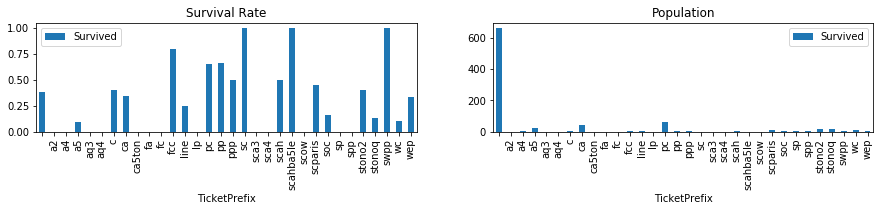

In [352]:
fig, axes = plt.subplots(nrows=1, ncols=2)
_ = df[['TicketPrefix', 'Survived']].groupby(['TicketPrefix']).agg('mean').plot.bar(title='Survival Rate', ax=axes[0], figsize=(15, 2))
_ = df[['TicketPrefix', 'Survived']].groupby(['TicketPrefix']).agg('count').plot.bar(title='Population', ax=axes[1])

For many of these ticket prefixes, there are too few passengers for us to really be able to draw any conclusion. Let's try merging some of the other prefixes that have similar survival rates and prefix structure, then expand these into new binary columns.

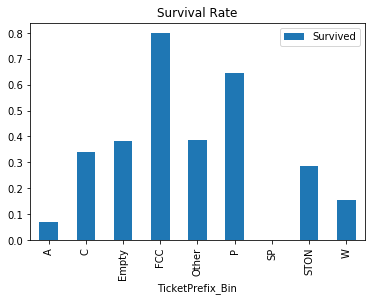

In [354]:
def prefix_bin(prefix):
    if prefix == '':
        return 'Empty'
    if prefix[:1] == 'a':
        return 'A'
    if prefix[:1] == 'c':
        return 'C'
    if prefix[:1] == 'p':
        return 'P'
    if prefix[:1] == 'w':
        return 'W'
    
    if prefix[:3] == 'fcc':
        return 'FCC'
    if prefix[:2] == 'sp':
        return 'SP'
    if prefix[:2] == 'scp':
        return 'SCP'
    if prefix[:4] == 'ston':
        return 'STON'

    return 'Other'

df['TicketPrefix_Bin'] = df['TicketPrefix'].apply(prefix_bin)

prefix_bins = pd.get_dummies(df['TicketPrefix_Bin']).add_prefix('TicketPrefix_')
df = df.merge(prefix_bins, how='left', left_index=True, right_index=True, validate='1:1')

_ = df[['TicketPrefix_Bin', 'Survived']].groupby(['TicketPrefix_Bin']).agg('mean').plot.bar(title='Survival Rate')
df = df.drop(columns=['TicketPrefix_Bin'])

For now, at least, that's a wrap for data cleaning!

# Data Classification

Now we can actually put our data to use and try to make a survival classifier out of this.

In [94]:
num_cols = df.select_dtypes('number').columns
df_numeric = df[num_cols]

In [95]:
train_df = df_numeric[~pd.isna(df_numeric['Survived'])]
train_df = train_df.dropna()
survived = train_df.pop('Survived')

X = train_df.to_numpy()
y = survived.to_numpy()

In [96]:
test_df = df_numeric[pd.isna(df_numeric['Survived'])]
_ = test_df.pop('Survived')
test_df = test_df.fillna(0)

X_Evaluation = test_df.to_numpy()

# Individual Classifier Performance

We're going to start by looking at inidviudal classifiers, discussing their pros and cons for the type of data we're working with

In [97]:
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import ShuffleSplit, cross_validate, cross_val_score
from sklearn.metrics import recall_score

def best_fit_model(clf):
    scoring = ['f1', 'roc_auc', 'accuracy']
    scores = cross_validate(clf, X, y, scoring=scoring, cv=6, return_estimator=True)
    comb = scores['test_f1'] * scores['test_roc_auc'] * scores['test_accuracy']

    best_ind = np.argmax(comb)
    print("Best model: \n- F1: {:.3g} \n- ROC AUC: {:.3g} \n- Accuracy: {:.3g}".format(scores['test_f1'][best_ind], 
                                                                  scores['test_roc_auc'][best_ind],
                                                                  scores['test_accuracy'][best_ind]))
    best_model = scores['estimator'][best_ind]
    return best_model, scores

estimators = []

## Random Forest

In [98]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, criterion="entropy")

best_forest, svc_scores = best_fit_model(clf)

Best model: 
- F1: 0.823 
- ROC AUC: 0.931 
- Accuracy: 0.852


## MLP (Multi Layer Perceptron)

In [99]:
from sklearn.neural_network import MLPClassifier
n = X.shape[1]
clf = MLPClassifier(hidden_layer_sizes=(n, n, int(n/2), 6), random_state=0, max_iter=300)

best_mlp, scores = best_fit_model(clf)

Best model: 
- F1: 0.796 
- ROC AUC: 0.878 
- Accuracy: 0.846


## Adaboost Classifier

In [100]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=5, max_depth=10, criterion="entropy"), 
                         n_estimators=5,
                         random_state=0)

best_adaboost, scores = best_fit_model(clf)

Best model: 
- F1: 0.84 
- ROC AUC: 0.899 
- Accuracy: 0.872


## Naive Bayes Classifier

In [104]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

best_nb, scores = best_fit_model(clf)

Best model: 
- F1: 0.738 
- ROC AUC: 0.863 
- Accuracy: 0.77


## Voting Clasifier

In [105]:
from sklearn.ensemble import VotingClassifier

estimators = [
    ('Forest', best_forest),
    ('MLP', best_mlp),
    ('Adaboost', best_adaboost),
    ('Naive Bayes', best_nb)
]
clf = VotingClassifier(estimators=estimators, voting='soft')
best_eclf, scores = best_fit_model(clf)

Best model: 
- F1: 0.829 
- ROC AUC: 0.903 
- Accuracy: 0.859


# Making the Final Predicttions

In [102]:
y_pred = best_adaboost.predict(X_Evaluation)
df_pred = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': y_pred.astype(int)
})

df_pred.to_csv("../output/pred.csv", index=False)